We recommend using a new virtual environment

In [ ]:
pip install netCDF4 dask superposed-pulses blobmodel fppanalysis closedexpressions

Let's create a synthetic time series

In [1]:
# Import the stuff we need
%matplotlib notebook
import matplotlib.pyplot as plt
import model.point_model as pm
import numpy as np
import fppanalysis as fa
from scipy import signal
import closedexpressions as ce

100%|█████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 7674.63it/s]


<IPython.core.display.Javascript object>


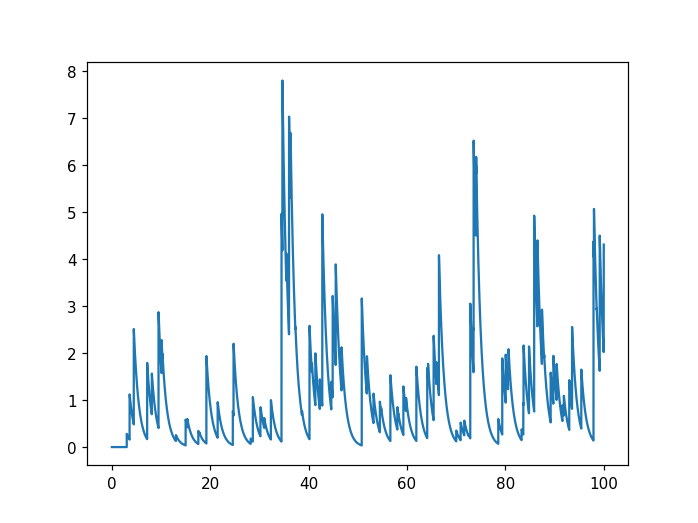

In [2]:
model = pm.PointModel(gamma=1, total_duration=100, dt=0.01)
time_array, signal_array = model.make_realization()

plt.plot(time_array, signal_array)
plt.show()


<IPython.core.display.Javascript object>


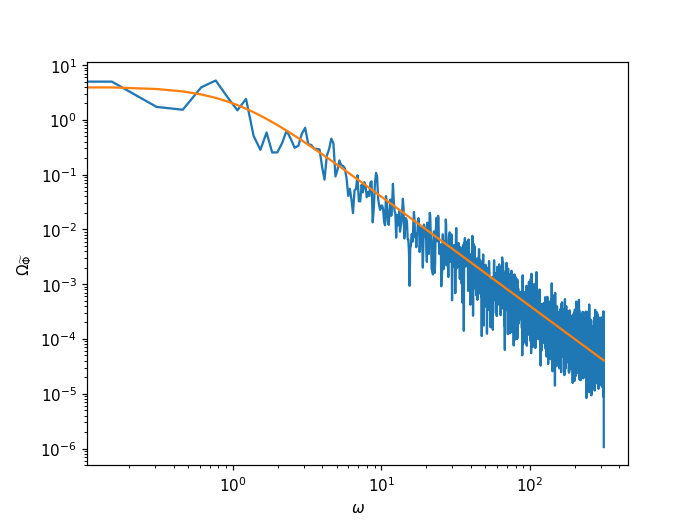

Text(0, 0.5, '$\\Omega_{\\widetilde{\\Phi}}$')

In [3]:
# Estimate the pulse shape by plotting the power spectra density using Welch method

signal_normalized = (signal_array - signal_array.mean())/signal_array.std()

frequency, power_spectra = signal.welch(x=signal_normalized, fs=1/0.01, nperseg=2**12)

omega = 2 * np.pi * frequency

# Using curve_fit, we estimate the average duration time of the pulses and the asymmetry parameter


plt.figure('power spectral density')
plt.loglog(omega, power_spectra)
plt.loglog(omega, ce.psd(omega, 1, 0.00))
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\Omega_{\widetilde{\Phi}}$')

In [4]:
# Function for a two-sided exponential pulse

def get_double_exponential_shape(
        times: np.ndarray, duration: float, lam: float
    ) -> np.ndarray:
        assert (lam >= 0.0) & (lam < 1.0)
        kern = np.zeros(len(times))
        kern[times < 0] = np.exp(times[times < 0] / lam / duration)
        kern[times >= 0] = np.exp(-times[times >= 0] / (1 - lam) / duration)
        return kern

<IPython.core.display.Javascript object>


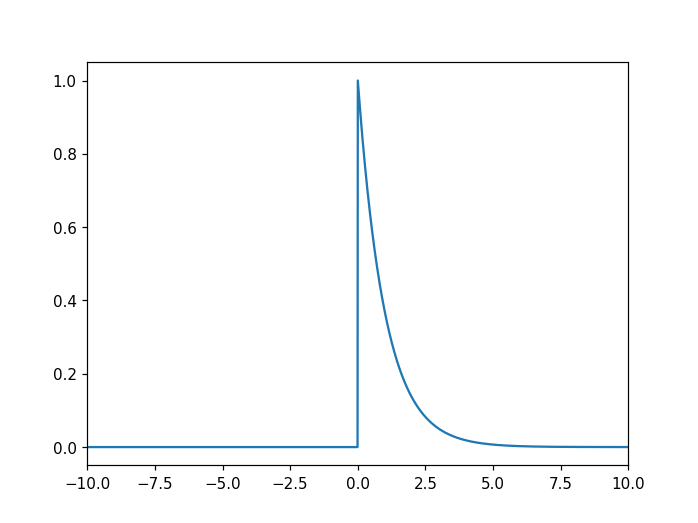

(-10.0, 10.0)

In [5]:
dt=0.01
kern_size = 2**11
time_kern = np.arange(-kern_size, kern_size + 1) * dt
kern_array = get_double_exponential_shape(time_kern, 1, lam=0.00)

plt.figure('pulse shape')
plt.plot(time_kern,kern_array)
plt.xlim(-10,10)

In [6]:
# Run the deconvolution

forcing, error = fa.RL_gauss_deconvolve(signal=signal_array,kern=kern_array,iteration_list=int(1e3),gpu=False)

 97%|████████████████████████████████████████████████████████▍ | 974/1000 [00:00<00:00, 1117.54it/s]

i = 1000


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1072.83it/s]


<IPython.core.display.Javascript object>


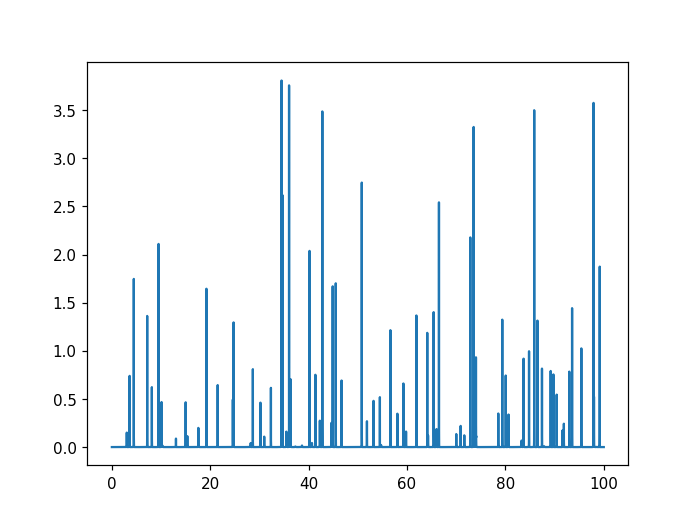

<IPython.core.display.Javascript object>


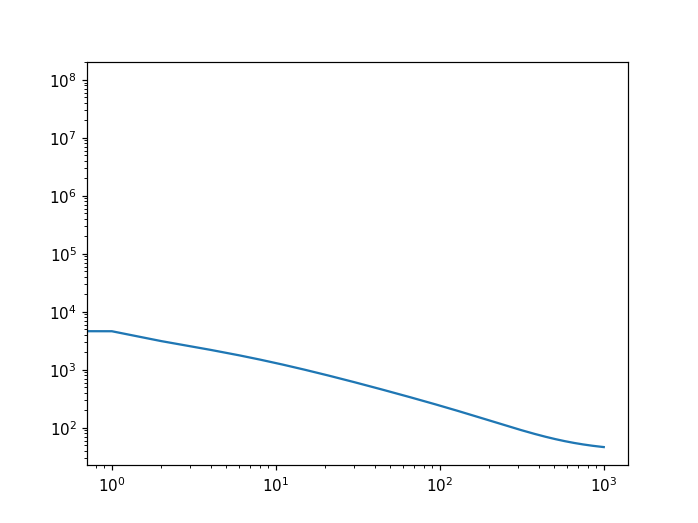

In [7]:
plt.figure('forcing')
plt.plot(time_array, forcing[:, -1])
plt.show()

plt.figure('error')
plt.loglog(error)

<IPython.core.display.Javascript object>


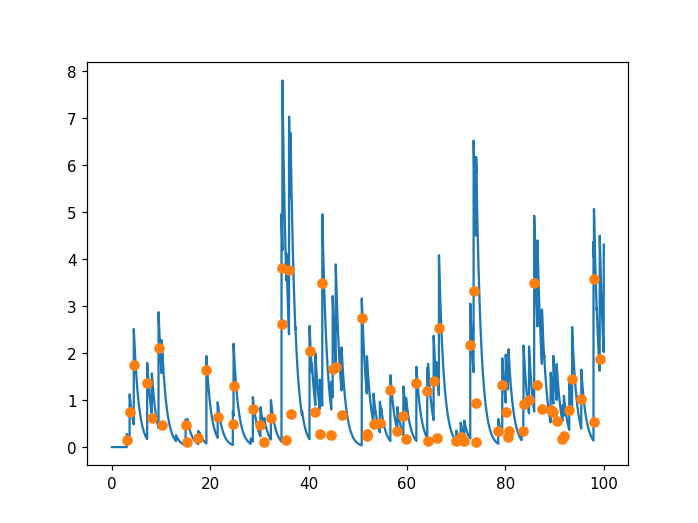

In [8]:
# We use a three-point running maxima to extract amplitudes and arrival times

estimated_arrivals, estimated_amplitudes = fa.three_point_maxima(forcing[:, -1], time_array, height=0.1)

plt.figure()
plt.plot(time_array, signal_array, label='Realization')
plt.plot(estimated_arrivals, estimated_amplitudes, marker='o', linestyle='None', label='Amplitudes')
plt.show()

We can extend the model by adding a radial coordinate:

In [9]:
from blobmodel import Model, show_model

bm = Model(Nx=200, Ny=1, Lx=10, Ly=0, dt=0.1, T=20, blob_shape='exp',num_blobs=100)

ds = bm.make_realization(file_name="example.nc")

Summing up Blobs: 100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 528.16it/s]


<IPython.core.display.Javascript object>


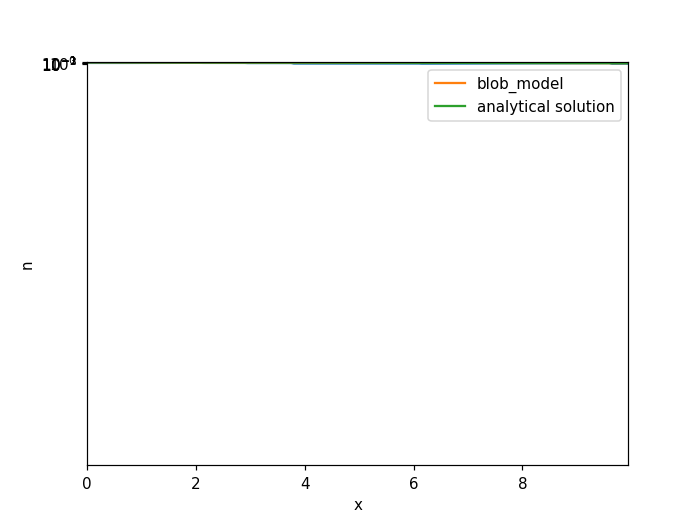

In [10]:
show_model(ds, save=True, gif_name = 'evolving_profile.gif')

In [12]:
# from IPython.display import Image
# Image(filename="evolving_profile.gif")

Summing up Blobs: 100%|█████████████████████████████████████| 10000/10000 [00:01<00:00, 6153.74it/s]


<IPython.core.display.Javascript object>


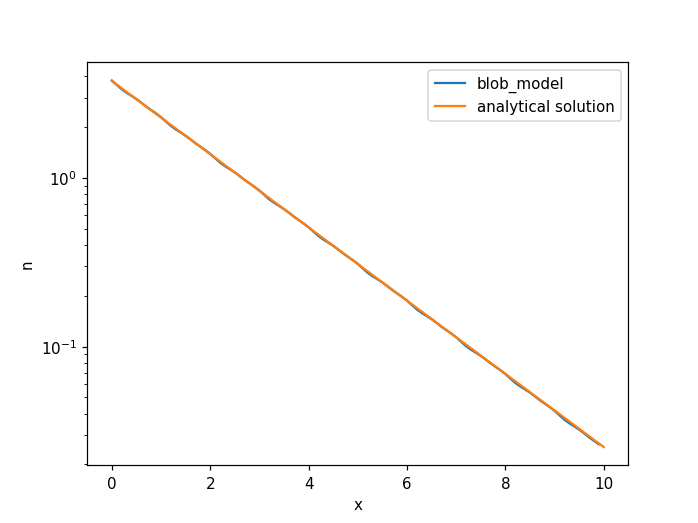

In [18]:
from blobmodel import Model, DefaultBlobFactory
import numpy as np

# use DefaultBlobFactory to define distribution functions fo random variables
bf = DefaultBlobFactory(A_dist="deg", W_dist="deg", vx_dist="deg", vy_dist="zeros")

tmp = Model(
    Nx=100,
    Ny=1,
    Lx=10,
    Ly=0,
    dt=1,
    T=1000,
    blob_shape="exp",
    t_drain=2,
    periodic_y=False,
    num_blobs=10000,
    blob_factory=bf,
)

ds = tmp.make_realization(file_name="profile_comparison.nc", speed_up=True, error=1e-2)


def plot_convergence_to_analytical_solution(ds):

    x = np.linspace(0, 10, 100)
    t_p = 1
    t_w = 1 / 10
    amp = 1
    v_p = 1.0
    t_loss = 2.0
    t_d = t_loss * t_p / (t_loss + t_p)

    analytical_profile = (
        1 / np.sqrt(np.pi) * t_d / t_w * amp * np.exp(-x / (v_p * t_loss))
    )

    plt.figure()
    ds.n.isel(y=0).mean(dim=("t")).plot(label="blob_model")
    plt.yscale("log")
    plt.plot(x, analytical_profile, label="analytical solution")
    plt.legend()
    plt.show()


plot_convergence_to_analytical_solution(ds)

Summing up Blobs: 100%|███████████████████████████████████████████| 100/100 [00:18<00:00,  5.51it/s]


<IPython.core.display.Javascript object>


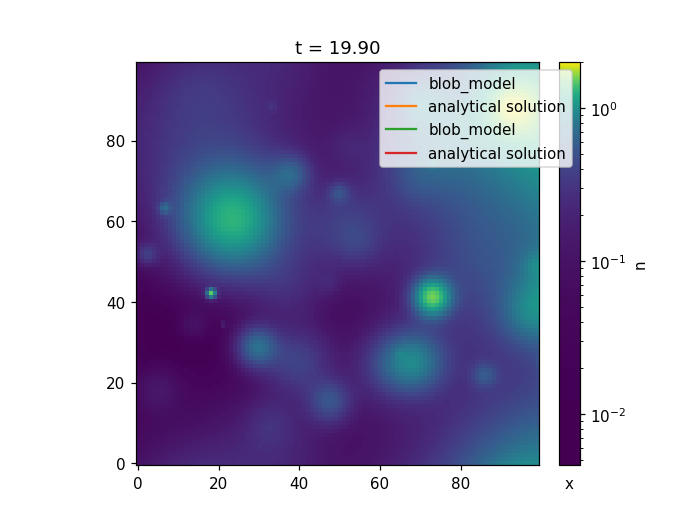

In [14]:
from blobmodel import Model, show_model

# here you can define your custom parameter distributions

bm = Model(
    Nx=100,
    Ny=100,
    Lx=10,
    Ly=10,
    dt=0.1,
    T=20,
    periodic_y=True,
    blob_shape="gauss",
    num_blobs=100,
    t_drain=1e10,
)

# create data
ds = bm.make_realization(speed_up=True, error=1e-2)
# show animation and save as gif
show_model(dataset=ds, interval=100, save=True, gif_name="2d_blobs.gif", fps=10)

In [21]:
# from IPython.display import Image
# Image(filename="2d_blobs.gif")